In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict, load_from_disk
from sklearn.model_selection import train_test_split
import os, re, fuzzysearch
from re import match, sub
from text_anonymizer.entity import EntityList, Entity, EntityType
from text_anonymizer.file_processing import read_inputs, create_pdf
from text_anonymizer.anonymization_helpers import normalize_text, check_full_word, remove_duplicate_entities
from IPython.display import display, HTML
from text_anonymizer.entity import highlight_entities_in_text
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2


In [ ]:
df = pd.read_json('')
names_df = pd.read_json('')
dfo4 = pd.read_json('ollama4.json')

In [5]:
len(dfo4['file'].unique()), len(dfo4), len(dfo4_run2)

(24953, 24953, 26652)

## Joins all PII searches done with ollama and different LLaMa models

In [ ]:
joined_df = pd.merge(df, dfo4, on="file", how="left", suffixes=("", "_dfo4"))
print(joined_df.iloc[10]['report'])

In [ ]:
def combine_piis(row):
  combined = []
  for col in ['piis', 'piis_dfo4', 'piis_names']:
    value = row[col]
    if isinstance(value, list):
      combined += value
  return combined

joined_df['piis_combined'] = None
for index, row in joined_df.iterrows():
  combined_piis = combine_piis(row)
  joined_df.at[index, 'piis_combined'] = combined_piis

In [ ]:
joined_df = joined_df.drop(columns=["piis_dfo4", "piis", "piis_names"])

In [12]:
joined_df = joined_df.rename(columns={"piis_combined": "piis"})

In [13]:
ollama4_names = []
with open('ollama4.log') as f:
  lines = f.readlines()
  for line in lines:
    if "Removing entity type 'PERSON_NAME'" in line:
      name = line.split("commas, spaces:")[1].strip()
      # If there are no numbers in the name, add it to the list
      if not any(char.isdigit() for char in name) and len(name) < 50:
        ollama4_names.append(name)

print(len(ollama4_names))
      

81


In [ ]:
df_drnames = pd.read_json('')
df_drnames = df_drnames.dropna(subset=['piis'])

dr_names = []
for piis in df_drnames['piis']:
  for pii in piis:
    if pii['type'] == 'PERSON_NAME':
      name = pii['sequence']
      if 'dr.' in name.lower() or 'med.' in name.lower() or 'prof.' in name.lower():
        dr_names.append(name)


In [ ]:
dr_names = list(set(dr_names))
print(len(dr_names))
for name in dr_names:
  if len(name.lower().replace('dr.', '').replace('prof.','').replace('med.','').replace('dr.med','').strip()) < 3:
    print(name)
    dr_names.remove(name)
  elif len(name.lower().replace('dr.med','').strip()) < 3:
    print(name)
    dr_names.remove(name)
  if 'mit freundlichen' in name.lower():
    dr_names.remove(name)
print(len(dr_names))

In [ ]:
dr_names.sort(key=lambda x: len(x))
print(dr_names)

In [ ]:
dr_names = list(set(dr_names))
print(len(dr_names), dr_names[:10])

In [16]:
df = joined_df
print(len(df))

26787


In [17]:
df = df.dropna(subset=['piis'])
df = df[df['piis'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
print(len(df))

26787


In [19]:
count = 0
for i, row in df.iterrows():
  if len(row['piis']) == 0:
    count += 1

count

0

# Additional PII Search


We look for additional PIIs with different techniques and manually crafted rules

In [ ]:
for index, row in df.iterrows():
  input_text = row['report']
  cleaned_text = sub(r'[\r\t\n\xa0\0\v\f]', ' ', input_text)
  cleaned_text = sub(r' +', ' ', cleaned_text)
  cleaned_text = cleaned_text.strip()
  for sequence in []:
    if sequence in cleaned_text:
      piis = row['piis']
      piis.append({'sequence': sequence, 'type': 'ADDRESS'})
      # df.at[index, 'piis'] = [pii for pii in piis if sequence not in pii]
      df.at[index, 'piis'] = piis


  for sequence in []: # Removed PIIs in array for privacy
    if sequence in cleaned_text:
      piis = row['piis']
      piis.append({'sequence': sequence, 'type': 'TELEPHONE'})
      # df.at[index, 'piis'] = [pii for pii in piis if sequence not in pii]
      df.at[index, 'piis'] = piis


  for sequence in []: # Removed PIIs in array for privacy
    if sequence in cleaned_text:
      piis = row['piis']
      piis.append({'sequence': sequence, 'type': 'PERSON_NAME'})
      # df.at[index, 'piis'] = [pii for pii in piis if sequence not in pii]
      df.at[index, 'piis'] = piis

  # for sequence in dr_names:
  #   if sequence in cleaned_text:
  #     piis = row['piis']
  #     piis.append({'sequence': sequence, 'type': 'PERSON_NAME'})
  #     # df.at[index, 'piis'] = [pii for pii in piis if sequence not in pii]
  #     df.at[index, 'piis'] = piis

  
  for sequence in ollama4_names:
    if sequence in cleaned_text:
      piis = row['piis']
      piis.append({'sequence': sequence, 'type': 'PERSON_NAME'})
      df.at[index, 'piis'] = [pii for pii in piis if sequence not in pii]

  # for sequence in all_names:
  #   if sequence in cleaned_text:
  #     piis = row['piis']
  #     piis.append({'sequence': sequence, 'type': 'PERSON_NAME'})
  #     df.at[index, 'piis'] = [pii for pii in piis if sequence not in pii]
  
  for sequence in []: # Removed PIIs in array for privacy
    if sequence in cleaned_text:
      piis = row['piis']
      piis.append({'sequence': sequence, 'type': 'DATE'})
      # df.at[index, 'piis'] = [pii for pii in piis if sequence not in pii]
      df.at[index, 'piis'] = piis

In [21]:
df['label'] = None

In [ ]:
count = 0
empfohlen = 0
no_procedere = 0
no_closing = 0
for index, row in df.iterrows():
  procedere = closing = -1
  input_text = row['report']
  cleaned_text = sub(r'[\r\t\n\xa0\0\v\f]', ' ', input_text)
  cleaned_text = sub(r' +', ' ', cleaned_text)
  cleaned_text = cleaned_text.strip()
  lower = cleaned_text.lower()
  if "procedere:" in lower:
    search_term = "procedere:"
  else:
    search_term = "procedere"
  procedere = lower.find(search_term)
  if procedere != -1:
    if 'mit freundliche' in lower[procedere:]:
      closing = procedere + lower[procedere:].find('mit freundliche') # correct possible "mit freundlicheM"

    elif 'wir bitten zu diesem' in lower[procedere:]:
      closing = lower[procedere:].find('wir bitten zu diesem') + procedere

    elif 'wir bitten deshalb um wiedervorstellung' in lower[procedere:]:
      closing = lower[procedere:].find('wir bitten deshalb um wiedervorstellung') + procedere

    elif 'direktor der orthop' in lower[procedere:]:
      closing = lower[procedere:].find('direktor der orthop') + procedere
    elif 'direktor der klinik' in lower[procedere:]:
      closing = lower[procedere:].find('direktor der klinik') + procedere
      
    else:
      if len(lower[procedere:]) > 1000:
        print(len(lower[procedere:]), lower[procedere:])
      else:
        closing = len(lower) - 1
          # break
        #   break
    # if closing == -1:
    #   closing = procedere + lower[procedere:].find('wir bitten zu diesem')

  if procedere == -1:
    no_procedere += 1
  if closing == -1:
    no_closing += 1
  
  if procedere != -1 and closing != -1:
    df.at[index, 'label'] = cleaned_text[procedere+len(search_term):closing].strip()
  elif procedere != -1 and closing == -1:
    df.at[index, 'label'] = cleaned_text[procedere+len(search_term):].strip()
  else:
    df.at[index, 'label'] = None

  if closing - procedere < 10:
    print(index, cleaned_text[procedere:closing])
    df.at[index, 'label'] = None
print(count, empfohlen, no_procedere, no_closing)

In [ ]:
def detect_telf_instances(text):
  results = []
  for match in re.finditer("telf_prefix", text): #Replaced the original prefix for "telf_prefix" for anonymization purposes
    start_index = match.start()
    # Find the next character that is a letter from A-Z or a-z after the match
    next_char_index = None
    for i in range(match.end(), len(text)):
      if text[i].isalpha():
        next_char_index = i-1
        while text[next_char_index-1] in ['-', ' ', '/', ')', ',', '.']:
          next_char_index -= 1
        break
    if next_char_index is not None:
      if text[start_index-1] == "(":
        start_index -= 1
      if text[next_char_index] == ")":
        next_char_index += 1
      results.append({'sequence': text[start_index:next_char_index], 'type': 'TELEPHONE'})
  return results

In [ ]:
for index, row in df.iterrows():
  input_text = row['report']
  cleaned_text = sub(r'[\r\t\n\xa0\0\v\f]', ' ', input_text)
  cleaned_text = sub(r' +', ' ', cleaned_text)
  cleaned_text = cleaned_text.strip()
  phones = detect_telf_instances(cleaned_text)
  piis = row['piis']
  piis += phones
  df.at[index, 'piis'] = piis

In [25]:
df = df.dropna(subset=['label'])
print(len(df))

26781


In [26]:
df = df[df['label'].str.len() >= 50]
print(len(df))

26699


In [27]:
df = df[df['label'].str.len() <= 1000]
print(len(df))

26306


In [28]:
import string

def remove_starting_punctuation(label):
  if label:
    # Remove punctuation from the start of the label
    return label.lstrip(string.punctuation).strip()
  return label

df['label'] = df['label'].apply(remove_starting_punctuation)

In [ ]:
for i in range(10):
  print(f"Procedere: {df.iloc[i]['label']}")

# PII Span location

In [ ]:
PHONE_PREFIX = "" #Removed for anonym. purposes

for index in range(0, 10):
    detected_entities = remove_duplicate_entities(df.at[index, 'piis'], ignore_start_end=True)
    detected_entities = EntityList(entities=detected_entities).entities
    found_entities = []
    input_text = df.at[index, 'report']
    cleaned_text = sub(r'[\r\t\n\xa0\0\v\f]', ' ', input_text)
    cleaned_text = sub(r' +', ' ', cleaned_text)
    cleaned_text = cleaned_text.strip()

    for entity in detected_entities:
        # if entity.type in {EntityType.PERSON_NAME, EntityType.DATE, EntityType.ADDRESS}:
        if 'patient' in entity.sequence.lower():
            continue
        search_sequences = [entity.sequence]
        if entity.type == EntityType.PERSON_NAME:
            search_sequences += [re.sub(r'\W[\r\t\n\xa0\0\v\f]', '', seq).strip() for seq in entity.sequence.split()]
            
        for search_sequence in search_sequences:
            if len(search_sequence) < 3:
                continue
            elif len(search_sequence) < 5:
                max_l_dist = 0
            elif len(search_sequence) <= 10 or re.match(r'^\d{1,2}\.\d{1,2}\.\d{2,4}$ | d{5}', search_sequence):
                max_l_dist = 1
            elif PHONE_PREFIX in search_sequence or len(search_sequence) > 10:
                max_l_dist = 2
            found = fuzzysearch.find_near_matches(normalize_text(search_sequence.lower()), cleaned_text.lower(), max_l_dist=max_l_dist)
            found = check_full_word(found, cleaned_text, entity_type=entity.type, cutoff=0.8, only_full_words=True)
            found_entities.extend([Entity(**e) for e in found])
            for f in found_entities:
                if len(f.sequence) < 2:
                    found_entities.remove(f)
    found_entities = remove_duplicate_entities(found_entities, ignore_start_end=False)
    print(found_entities)
    found_entities = EntityList(entities=found_entities).entities
    display(HTML(highlight_entities_in_text(cleaned_text, found_entities)))
    print(df.at[index, 'file'], index)
    print("-----------------")

    label = df.at[index, 'label']
    if label is not None:
        label = sub(r'[\r\t\n\xa0\0\v\f]', ' ', label)
        label = sub(r' +', ' ', label)
        label = label.strip()
        found_entities = []
        for entity in detected_entities:
            if 'patient' in entity.sequence.lower():
                continue
            # if entity.type in {EntityType.PERSON_NAME, EntityType.DATE, EntityType.ADDRESS}:
            search_sequences = [entity.sequence]
            if entity.type == EntityType.PERSON_NAME:
                search_sequences += [re.sub(r'\W[\r\t\n\xa0\0\v\f]', '', seq).strip() for seq in entity.sequence.split()]

                
            for search_sequence in search_sequences:
                if len(search_sequence) < 3:
                    continue
                elif len(search_sequence) < 5:
                    max_l_dist = 0
                elif len(search_sequence) < 10 or re.match(r'^\d{1,2}\.\d{1,2}\.\d{2,4}$ | d{5}', search_sequence):
                    max_l_dist = 1
                elif PHONE_PREFIX in search_sequence:
                    max_l_dist = 2
                else:
                    max_l_dist = 2
                found = fuzzysearch.find_near_matches(normalize_text(search_sequence.lower()), label.lower(), max_l_dist=max_l_dist)
                found = check_full_word(found, label, entity_type=entity.type, cutoff=0.8, only_full_words=True)
                found_entities.extend([Entity(**e) for e in found])
                for f in found_entities:
                    if len(f.sequence) < 2:
                        print(search_sequence,f)
                        found_entities.remove(f)

        found_entities = remove_duplicate_entities(found_entities, ignore_start_end=False)
        found_entities = EntityList(entities=found_entities).entities

        display(HTML(highlight_entities_in_text(label, found_entities)))
    print("#############-------------------------------###################")
# found_entities

# Dataset creation

In [ ]:
PHONE_PREFIX = "" #Removed for anonym. purposes

for index, row in df.iterrows():
    detected_entities = remove_duplicate_entities(df.at[index, 'piis'], ignore_start_end=True)
    i = 0 
    while i < len(detected_entities):
        if detected_entities[i]['type'] not in ['PERSON_NAME', 'DATE', 'ADDRESS', 'TELEPHONE', 'EMAIL', 'WEBSITE', 'POST_CODE']:
            detected_entities.pop(i)
        elif len(detected_entities[i]['sequence']) < 2:
            detected_entities.pop(i)
        else:
            i += 1
        
    # print(detected_entities)
    detected_entities = EntityList(entities=detected_entities).entities
    found_entities = []
    input_text = df.at[index, 'report']
    cleaned_text = sub(r'[\r\t\n\xa0\0\v\f]', ' ', input_text)
    cleaned_text = sub(r' +', ' ', cleaned_text)
    cleaned_text = cleaned_text.strip()

    for entity in detected_entities:
        # if entity.type in {EntityType.PERSON_NAME, EntityType.DATE, EntityType.ADDRESS}:
        if 'patient' in entity.sequence.lower():
            continue
        search_sequences = [entity.sequence]
        if entity.type == EntityType.PERSON_NAME:
            search_sequences += [re.sub(r'\W[\r\t\n\xa0\0\v\f]', '', seq).strip() for seq in entity.sequence.split()]
            
        for search_sequence in search_sequences:
            if len(search_sequence) < 3:
                continue
            elif len(search_sequence) < 5:
                max_l_dist = 0
            elif len(search_sequence) <= 10 or re.match(r'^\d{1,2}\.\d{1,2}\.\d{2,4}$ | d{5}', search_sequence):
                max_l_dist = 1
            elif PHONE_PREFIX in search_sequence or len(search_sequence) > 10:
                max_l_dist = 2
            found = fuzzysearch.find_near_matches(normalize_text(search_sequence.lower()), cleaned_text.lower(), max_l_dist=max_l_dist)
            found = check_full_word(found, cleaned_text, entity_type=entity.type, cutoff=0.8, only_full_words=True)
            found_entities.extend([Entity(**e) for e in found])
            for f in found_entities:
                if len(f.sequence) < 2:
                    found_entities.remove(f)
    found_entities = remove_duplicate_entities(found_entities, ignore_start_end=False)
    found_entities = EntityList(entities=found_entities).entities
    piis = []
    for entity in found_entities:
        piis.append(entity.model_dump())
    df.at[index, 'piis'] = piis
    # display(HTML(highlight_entities_in_text(cleaned_text, found_entities)))

    label = df.at[index, 'label']
    if label is not None:
        label = sub(r'[\r\t\n\xa0\0\v\f]', ' ', label)
        label = sub(r' +', ' ', label)
        label = label.strip()
        found_entities = []
        for entity in detected_entities:
            if 'patient' in entity.sequence.lower():
                continue
            
            search_sequences = [entity.sequence]
            if entity.type == EntityType.PERSON_NAME:
                search_sequences += [re.sub(r'\W[\r\t\n\xa0\0\v\f]', '', seq).strip() for seq in entity.sequence.split()]

                
            for search_sequence in search_sequences:
                if len(search_sequence) < 3:
                    continue
                elif len(search_sequence) < 5:
                    max_l_dist = 0
                elif len(search_sequence) < 10 or re.match(r'^\d{1,2}\.\d{1,2}\.\d{2,4}$ | d{5}', search_sequence):
                    max_l_dist = 1
                elif PHONE_PREFIX in search_sequence:
                    max_l_dist = 2
                else:
                    max_l_dist = 2
                found = fuzzysearch.find_near_matches(normalize_text(search_sequence.lower()), label.lower(), max_l_dist=max_l_dist)
                found = check_full_word(found, label, entity_type=entity.type, cutoff=0.8, only_full_words=True)
                found_entities.extend([Entity(**e) for e in found])
                for f in found_entities:
                    if len(f.sequence) < 2:
                        found_entities.remove(f)

        found_entities = remove_duplicate_entities(found_entities, ignore_start_end=False)
        found_entities = EntityList(entities=found_entities).entities

        procedere = -1
        lower = cleaned_text.lower()
        if "procedere:" in lower:
            search_term = "procedere:"
        else:
            search_term = "procedere"
        procedere = lower.find(search_term)
        df.at[index, 'input_text'] = cleaned_text[:procedere].strip()

        # display(HTML(highlight_entities_in_text(label, found_entities)))
# found_entities

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

In [ ]:
# Calculate lengths of input_text and label for each entry in df
input_lengths = df['input_text'].apply(lambda x: len(tokenizer(x)['input_ids']))
label_lengths = df['label'].apply(lambda x: len(tokenizer(x)['input_ids']))

plt.figure(figsize=(12, 5))

# Histogram for input_text lengths
plt.subplot(1, 2, 1)
plt.hist(input_lengths, bins=30, color='skyblue', alpha=0.7)
plt.title('Input Text Length Distribution')
plt.xlabel('Length (tokens)')
plt.ylabel('Frequency')

# Histogram for label lengths
plt.subplot(1, 2, 2)
plt.hist(label_lengths, bins=30, color='lightgreen', alpha=0.7)
plt.title('Label Length Distribution')
plt.xlabel('Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [31]:
train_set, temp_set = train_test_split(
  df, test_size=0.2, random_state=42
)
val_set, test_set = train_test_split(
  temp_set, test_size=0.5, random_state=42
)

print("Train set shape:", train_set.shape)
print("Validation set shape:", val_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (21044, 6)
Validation set shape: (2631, 6)
Test set shape: (2631, 6)


In [35]:
print("Train set columns:", train_set.columns)
print("Validation set columns:", val_set.columns)
print("Test set columns:", test_set.columns)

Train set columns: Index(['report', 'file', 'id', 'piis', 'label', 'input_text'], dtype='object')
Validation set columns: Index(['report', 'file', 'id', 'piis', 'label', 'input_text'], dtype='object')
Test set columns: Index(['report', 'file', 'id', 'piis', 'label', 'input_text'], dtype='object')


In [ ]:
dataset = DatasetDict({
  'train': Dataset.from_pandas(train_set),
  'validation': Dataset.from_pandas(val_set),
  'test': Dataset.from_pandas(test_set)
})

In [ ]:
dataset.save_to_disk('')

# Create TP Attack Dataset

In [ ]:
dataset = load_from_disk('')

In [3]:
len(dataset['train']), len(dataset['validation']), len(dataset['test']), sum([len(dataset['train']), len(dataset['validation']), len(dataset['test'])])

(21044, 2631, 2631, 26306)

In [4]:
train_set = dataset['train']

In [ ]:
train_set[0]['label']

In [ ]:
max_len = 0
for row in train_set:
  length = len(tokenizer(row['input_text']).input_ids)
  if length > max_len:
    max_len = length
  
print(max_len)

3938


In [5]:
def generate_prompt_and_label(example):
    prompt = (
        f'You are a medical language model trained to write the "Procedere" section of a German-language discharge summary from an orthopedic clinic.'
        f'Based on the following clinical information, you are to generate the text for the "Procedere" section.'
        f'The output must be medically accurate, written in German, and adhere to the standard clinical writing style.\n'
        f'<BEGINNING OF CLINICAL INFORMATION>\n{example["input_text"]}\n<END OF CLINICAL INFORMATION>\n'
        f'Please now generate the section.'
        f'Procedere: {example["label"]}\n'
    )
    return prompt

In [ ]:
def generate_prompt(example):
    prompt = (
        f'You are a medical language model trained to write the "Procedere" section of a German-language discharge summary from an orthopedic clinic.'
        f'Based on the following clinical information, you are to generate the text for the "Procedere" section.'
        f'The output must be medically accurate, written in German, and adhere to the standard clinical writing style.\n'
        f'<BEGINNING OF CLINICAL INFORMATION>\n{example}\n<END OF CLINICAL INFORMATION>\n'
        f'Please now generate the section.'
        f'Procedere: '
    )
    return prompt

def preprocess_function(example, tokenizer):
    prompt = generate_prompt(example['input_text'])
    response = example['label'].strip() + tokenizer.eos_token
    full_text = prompt + response

    tokenized_full = tokenizer(full_text)
    tokenized_prompt = tokenizer(prompt)
    prompt_len = len(tokenized_prompt["input_ids"])

    labels = tokenized_full["input_ids"].copy()
    labels[:prompt_len] = [-100] * prompt_len
    tokenized_full["labels"] = labels

    if "label" in tokenized_full:
        del tokenized_full["label"]

    return tokenized_full

lens = [len(tokenizer(generate_prompt(ex) + ex['label'] + tokenizer.eos_token)['input_ids'])
    for ex in dataset['train']]
print(f"max={max(lens)}, 95th percentile={np.percentile(lens,95)}")

max=4369, 95th percentile=1327.0


In [ ]:
generate_prompt(dataset['train'][0])

In [6]:
df = pd.DataFrame.from_dict(dataset['train'])

In [7]:
prompts_and_labels = df.apply(generate_prompt_and_label, axis=1)

In [8]:
prompts_and_labels_lengths = prompts_and_labels.apply(lambda x: len(tokenizer(x)['input_ids']))

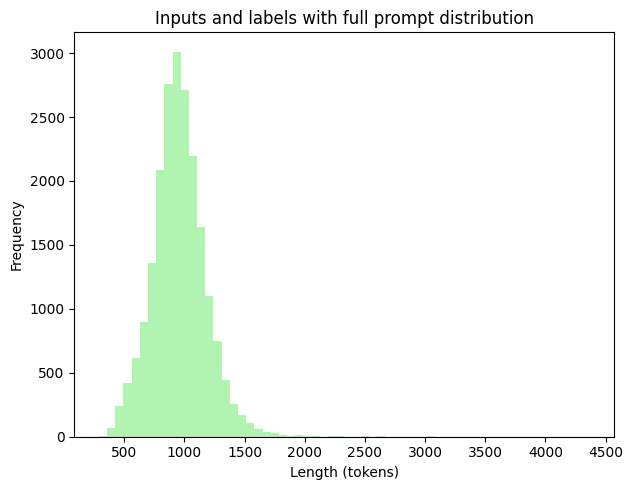

In [9]:
plt.figure(figsize=(12, 5))

# Histogram for input_text lengths
# plt.subplot(1, 2, 1)
# plt.hist(prompts_lengths, bins=30, color='skyblue', alpha=0.7)
# plt.title('Inputs with full prompt distribution')
# plt.xlabel('Length (tokens)')
# plt.ylabel('Frequency')

# Histogram for label lengths
plt.subplot(1, 2, 2)
plt.hist(prompts_and_labels_lengths, bins=60, color='lightgreen', alpha=0.7)
plt.title('Inputs and labels with full prompt distribution')
plt.xlabel('Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
skip_terms = set(text.lower() for text in []) # Common city names, places, and terms to skip (PII)
len(skip_terms)

600

In [ ]:
# iterate through train split to collect examples with ≥50-token prefixes before each PII
examples = []
fake_counts = {}
print(len(train_set))
for i in range(len(train_set)):
  text = train_set[i]["input_text"]
  for pii in train_set[i]["piis"]:
    seq = pii["sequence"]
    typ = pii["type"]
    if seq != text[pii["start"]:pii["end"]]:
      # print(f"Sequence mismatch: {seq} != {text[pii['start']:pii['end']]}")

      if seq in fake_counts:
        fake_counts[seq] += 1
      else:
        fake_counts[seq] = 1
    if seq.lower() in skip_terms:
      continue
    start = pii.get("start", None)
    # skip if no start offset
    if start is None:
      continue
    # get the text before the PII
    prefix = text[:start]
    # tokenize the prefix
    tokens = tokenizer.tokenize(prefix)
    # only keep if at least 50 tokens precede the PII

    if len(tokens) >= 100:
      last_50 = tokens[-100:]
      # convert tokens back to string for model input
      prefix_50_str = tokenizer.convert_tokens_to_string(last_50)
      if seq.lower() in prefix_50_str.lower():
        # if the sequence is already in the prefix, mask it
        index = prefix_50_str.lower().find(seq.lower())
        prefix_50_str = prefix_50_str[:index] + f"<{typ.split('.')[-1]}>" + prefix_50_str[index + len(seq):]
      for word in seq.split():
        # replace each word in the sequence with its type
        if word in prefix_50_str:
          prefix_50_str = prefix_50_str.replace(word, f"<{typ.split('.')[-1]}>")
      # for pii_prefix in train_set[i]["piis"]:
      #   if pii_prefix["sequence"] in prefix_50_str:
      #     prefix_50_str = prefix_50_str.replace(pii_prefix["sequence"], f"<{pii_prefix['type'].split('.')[-1]}>")
      result = {
        "input": prefix_50_str,
        "label": seq,
        "new_label": text[start:pii["end"]],
        "type": typ
      }
      if result not in examples:
        examples.append(result)
print(fake_counts)
# inspect number of collected examples
print(f"Collected {len(examples)} examples with ≥50-token prefixes")
# Collected 298150 examples with ≥50-token prefixes


In [ ]:
tp_dataset = pd.DataFrame(examples)
tp_dataset.to_json('', orient='records', indent=2) 

In [ ]:
for row in tp_dataset.itertuples():
    input_text = row.input
    tokenized_input = tokenizer(input_text)
    input_len = len(tokenized_input['input_ids'])
    if input_len > 10:
      # Get the last 50 tokens
      last_50_tokens = tokenized_input['input_ids'][-10:]
      # Convert tokens back to text
      last_50_text = tokenizer.decode(last_50_tokens, skip_special_tokens=True)
      # Update the DataFrame
      tp_dataset.at[row.Index, 'input'] = last_50_text
        
# Save the updated DataFrame
tp_dataset.to_json('', orient='records', indent=2) 


In [ ]:
tp_dataset = pd.read_json('', orient='records')
len(tp_dataset), tp_dataset.columns

(298150, Index(['input', 'label', 'new_label', 'type'], dtype='object'))

In [14]:
tp_dataset.drop(columns=['label'], inplace=True)
tp_dataset.rename(columns={'new_label': 'label'}, inplace=True)
tp_dataset = tp_dataset[tp_dataset['label'].str.len() > 1]
len(tp_dataset), tp_dataset.columns

(231445, Index(['input', 'label', 'type'], dtype='object'))

In [ ]:
tp_dataset.head(10)

In [16]:
tp_dataset = tp_dataset[tp_dataset['type'] == 'PERSON_NAME']

In [18]:
len(tp_dataset)

59770

In [ ]:
Dataset.from_pandas(tp_dataset).save_to_disk('')

Saving the dataset (1/1 shards): 100%|██████████| 59770/59770 [00:00<00:00, 2580611.97 examples/s]


In [ ]:
# Plot the most common labels in tp_dataset
import matplotlib.pyplot as plt

# Count label frequencies and take top 20
top_labels = tp_dataset['new_label'].value_counts().nlargest(21)[1:]

plt.figure(figsize=(12, 6))
top_labels.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 20 Most Common Labels in tp_dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
filtered_tp = tp_dataset[tp_dataset['type'] == 'PERSON_NAME']
filtered_tp = filtered_tp[filtered_tp['new_label'] != ''] # Removed for privacy
filtered_tp = filtered_tp[filtered_tp['new_label'] != ''] # Removed for privacy
top_labels = filtered_tp['new_label'].value_counts().nlargest(80)

plt.figure(figsize=(22, 8))
top_labels.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 20 Most Common Names")
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [702]:
# Keep only examples whose tokenized 'input' is at most 100 tokens
tp_others = tp_others.filter(
  lambda example: len(tokenizer(example["input"])["input_ids"]) <= 100
)
print(f"Rows after filtering: {len(tp_others)}")

Filter: 100%|██████████| 256102/256102 [00:19<00:00, 13033.85 examples/s]

Rows after filtering: 256079


In [55]:
# Remove duplicate rows based on 'input' and 'label'
tp_dataset = tp_dataset.drop_duplicates(subset=['type', 'label'])
print(f"Rows after deduplication: {tp_dataset.shape[0]} (columns: {tp_dataset.shape[1]})")

Rows after deduplication: 85214 (columns: 3)


In [ ]:
tp_dataset.to_json('', orient='records', indent=2)

In [ ]:
tp_dataset = pd.read_json('', orient='records')

In [ ]:
tp_dataset['type'].value_counts()

278667

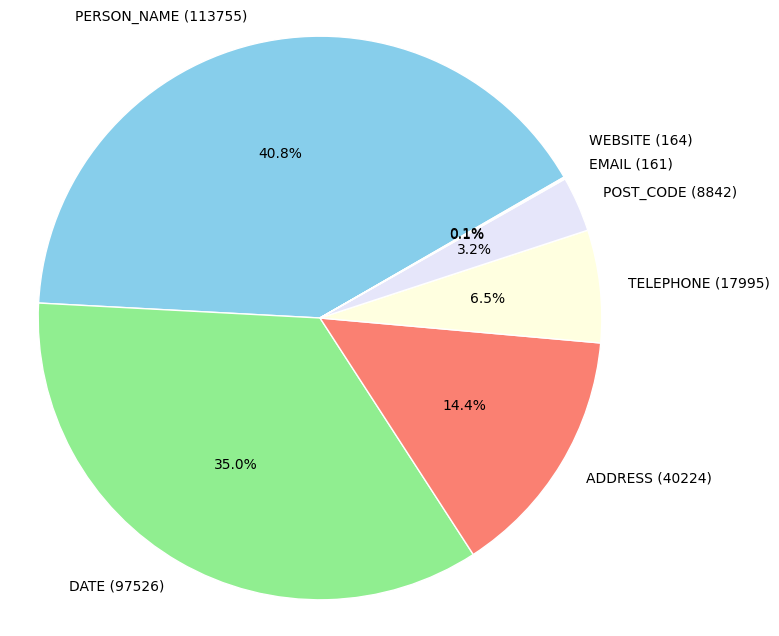

In [41]:
# Pie chart of PII types distribution in tp_dataset
type_counts = tp_dataset['type'].value_counts()

labels_with_counts = [
    f"{label} ({value})" if label != 'WEBSITE' else f"{label} ({value})\n\n\n"  # Hide WEBSITE label here
    for label, value in type_counts.items()
]


plt.figure(figsize=(8, 8))
plt.pie(
  type_counts.values,
  labels=labels_with_counts,#[f"{t} ({n})" for t, n in type_counts.items()],
  autopct='%1.1f%%',
  startangle=30,
  wedgeprops={'edgecolor': 'white'},
  # explode=explode,
  colors=['skyblue', 'lightgreen', 'salmon', 'lightyellow', 'lavender', 'lightgray'],
  # textprops={'bbox': dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none')}

)
# plt.title('PII Type Distribution in tp_dataset')
plt.axis('equal')
plt.show()

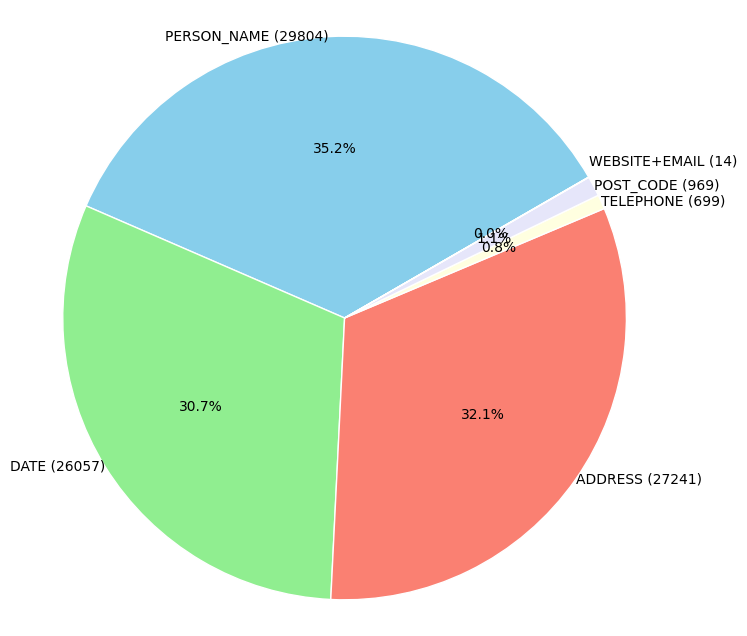

In [ ]:
import matplotlib.pyplot as plt


labels_with_counts = [
    f"{label} ({value})" if label != 'WEBSITE+EMAIL' else f"{label} ({value})\n\n"  # Hide WEBSITE label here
    for label, value in counts.items()
]
plt.figure(figsize=(8, 8))
plt.pie(
  counts.values(),
  labels=labels_with_counts,
  labeldistance=1,
  autopct='%1.1f%%',
  startangle=30,
  wedgeprops={'edgecolor': 'white'},
  colors=['skyblue', 'lightgreen', 'salmon', 'lightyellow', 'lavender', 'lightcoral']
)
# plt.title('Distribution of Unique PII Types')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()

In [ ]:
dataset = load_from_disk('')
len(dataset), dataset.column_names

(256079, ['input', 'label', 'type'])

In [697]:
len(dataset)

278781

In [ ]:
dataset.save_to_disk('')

Saving the dataset (1/1 shards): 100%|██████████| 278781/278781 [00:00<00:00, 466504.93 examples/s]


In [ ]:
max_length = 0
for input in dataset['input']:
  length = len(tokenizer(input)['input_ids'])
  if length >= 100:
    print(input)
print(f"Maximum input length in dataset: {max_length}")

In [ ]:
for _, row in tp_dataset.iterrows():
  if 'PII' in row['label'] and 'PII' in row['input']: #PII
    print(f"Found 'PII' in input: {row['input']}")
    print(f"Label: {row['label']}")
    print(f"Type: {row['type']}")
    

# DPO Dataset (1st approach, no sliding window)

In [ ]:
dataset = load_from_disk('')
val_dataset = dataset['validation']
len(val_dataset)

2631

In [ ]:
val_dataset[0:10]['label']

In [ ]:
for _, row in val_set.iterrows():
    print(row['label'])
    if _ == 10:
        break

In [ ]:

def generate_prompt(example):
    prompt = (
        f'You are a medical language model trained to write the "Procedere" section of a German-language discharge summary from an orthopedic clinic.'
        f'Based on the following clinical information, you are to generate the text for the "Procedere" section.'
        f'The output must be medically accurate, written in German, and adhere to the standard clinical writing style.\n'
        f'<BEGINNING OF CLINICAL INFORMATION>\n{example}\n<END OF CLINICAL INFORMATION>\n'
        f'Please now generate the section.\n'
        f'Procedere: '
    )
    return prompt


# Extract the two label series and the prompts
rejected = val_set['label'].reset_index(drop=True)
chosen = val_dataset['label']  # this is a list of labels
prompts = [generate_prompt(text) for text in val_dataset['input_text']]

# Combine into a DataFrame
comparison_df = pd.DataFrame({
  'rejected': rejected,
  'chosen': chosen,
  'prompt': prompts
})

comparison_df.head()

In [ ]:
index = 1561
print(comparison_df.iloc[index]['chosen'])
print(comparison_df.iloc[index]['rejected'])

In [256]:
comparison_df.at[index, 'chosen'] = comparison_df.at[index, 'chosen'].replace('Mai',
                                                                               '<DATE>')
comparison_df.to_json('DPO_dataset.json', orient='records', indent=2)

In [ ]:
comparison_df = pd.read_json('DPO_dataset.json', orient='records')
comparison_df.head()

In [3]:
# remove entries where rejected and chosen are identical
comparison_df = comparison_df.loc[
  comparison_df['rejected'] != comparison_df['chosen']
].reset_index(drop=True)

# optional: inspect remaining count
print(f"Remaining samples: {len(comparison_df)}")

Remaining samples: 1564


In [11]:
# create train / validation split for the comparison dataframe
train_df, val_df = train_test_split(comparison_df, test_size=0.1, random_state=42, shuffle=True)

print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")

Train set shape: (1407, 3)
Validation set shape: (157, 3)


In [12]:
dpo_dataset = DatasetDict({
  'train': Dataset.from_pandas(train_df),
  'validation': Dataset.from_pandas(val_df)
})

In [ ]:
dpo_dataset.save_to_disk('')

Saving the dataset (1/1 shards): 100%|██████████| 157/157 [00:00<00:00, 50779.28 examples/s]


In [ ]:
dpo_dataset = load_from_disk('')
print(f"{dpo_dataset['train'][0]['prompt']}")
print(f"{dpo_dataset['train'][0]['chosen']}")
print(f"{dpo_dataset['train'][0]['rejected']}")

In [3]:
# Cell 78: Update prompts in dpo_dataset to include masking instruction
def update_mask_instruction(example):
  example["prompt"] = example["prompt"].replace(
    "The output must be medically accurate, written in German, and adhere to the standard clinical writing style.",
    "The output must be medically accurate, written in German, and adhere to the standard clinical writing style. Please mask ONLY sensitive information"
  )
  return example

dpo_dataset = dpo_dataset.map(update_mask_instruction)


Map: 100%|██████████| 157/157 [00:00<00:00, 24455.22 examples/s]


In [ ]:
print(f"{dpo_dataset['train'][0]['prompt']}")
print(f"{dpo_dataset['train'][0]['chosen']}")
print(f"{dpo_dataset['train'][0]['rejected']}")

In [ ]:
dpo_dataset.save_to_disk('')

Saving the dataset (1/1 shards): 100%|██████████| 157/157 [00:00<00:00, 67373.21 examples/s]


In [ ]:
masked_dataset = pd.read_json('', orient='records')
len(masked_dataset)

276773

In [9]:
pii_types = masked_dataset['type'].unique()
for _, row in masked_dataset.iterrows():
  for type in pii_types:
    if f"<{type}>" in row['input']:
      # Remove the row
      masked_dataset = masked_dataset[masked_dataset['input'] != row['input']]
      break

len(masked_dataset)

      

68782

In [25]:
masked_dataset = masked_dataset[masked_dataset['label'] != 'und']

In [26]:
len(masked_dataset)

59739

In [ ]:
for _, row in masked_dataset.iterrows():
  if row['type'] == 'PERSON_NAME':
    print(row['input'], row['label'])

  if _ > 1000:
    break

In [ ]:
masked_dataset['label'].value_counts()

In [ ]:
masked_dataset.to_json('', orient='records', indent=2)

In [31]:
masked_dataset['type'].value_counts()

type
PERSON_NAME    29827
DATE           25240
TELEPHONE       4308
ADDRESS          296
POST_CODE         43
WEBSITE           16
EMAIL              9
Name: count, dtype: int64

In [32]:
masked_dataset = masked_dataset[masked_dataset['type'] == 'PERSON_NAME'].reset_index(drop=True)
len(masked_dataset)

29827

In [ ]:
masked_dataset.to_json('', orient='records', indent=2)

In [ ]:
Dataset.from_pandas(masked_dataset).save_to_disk('')

Saving the dataset (1/1 shards): 100%|██████████| 29827/29827 [00:00<00:00, 2417085.39 examples/s]


In [8]:
import matplotlib.pyplot as plt

In [ ]:
ft_counts = {}
for name in ft_names:
    if name in tp_dataset['label'].value_counts().index:
        ft_counts[name] = tp_dataset['label'].value_counts()[name]
    

llama_counts = {}
for name in llama_names:
    if name in tp_dataset['label'].value_counts().index:
        llama_counts[name] = tp_dataset['label'].value_counts()[name]

# Plot the 20 most common names in ft_counts and llama_counts
# Combine the counts into a single DataFrame
ft_df = pd.DataFrame(list(ft_counts.items()), columns=['Name', 'Count'])
llama_df = pd.DataFrame(list(llama_counts.items()), columns=['Name', 'Count'])
# Sort by count and take the top 20
ft_df = ft_df.sort_values(by='Count', ascending=False).head(20)
llama_df = llama_df.sort_values(by='Count', ascending=False).head(20)
# Plot the counts
plt.figure(figsize=(14, 7))
ft_df.plot(kind='bar', x='Name', y='Count', color='skyblue', edgecolor='black', legend=False, title='Top 20 Most Common Names in ft_names')
llama_df.plot(kind='bar', x='Name', y='Count', color='lightgreen', edgecolor='black', legend=False, title='Top 20 Most Common Names in llama_names')
plt.tight_layout()
plt.show()


In [ ]:
# Plot the 20 most common names in tp_dataset
names = tp_dataset[tp_dataset['label'] != ''] # Removed for privacy
names = names[names['label'] != ''] # Removed for privacy
names = names[names['label'] != ''] # Removed for privacy
names = names[names['label'] != ''] # Removed for privacy
names = names[names['label'] != ''] # Removed for privacy
names = names[names['label'] != ''] # Removed for privacy
names = names[names['label'] != ''] # Removed for privacy
names = names[names['label'] != ''] # Removed for privacy
names = names[names['type'] == 'PERSON_NAME']['label'].value_counts().nlargest(50)
plt.figure(figsize=(12, 6))
names.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 20 Most Common Names in tp_dataset')
plt.xlabel('Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()